<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ROC/AUC:" data-toc-modified-id="ROC/AUC:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ROC/AUC:</a></span><ul class="toc-item"><li><span><a href="#SMOTE:" data-toc-modified-id="SMOTE:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SMOTE:</a></span></li></ul></li><li><span><a href="#Pruning" data-toc-modified-id="Pruning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pruning</a></span></li><li><span><a href="#Decision-Tree:" data-toc-modified-id="Decision-Tree:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Decision Tree:</a></span></li></ul></div>

- Who is controlling 4 central squares: d4, d5, e4, e5
- Who captured the first piece
- Which player castles sooner
- Does player castle (yes, no)
- Who moves all of their pieces off of the back row the quickest

    # tutor.peterl@gmail.com

Logistic Regression
Matrix Feature adjustments (need name)
Feature importance
Subspace sampling
Ensemble methods
Random forest method
GridsearchCV (combinatorial, exhaustive)

Parameter Tuning

Grid Searching Cross val score for random forest classifier
AdaBoost - tuning gradient boosted trees
Gradient Boosting
Weak vs Strong learners
XGBoost - extreme gradient boosting

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import sqlalchemy
#from sqlalchemy import create_engine
#from sqlalchemy.orm import Session, sessionmaker
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
df = pd.read_csv('games.csv')
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [3]:
print(df.moves[:1])

0    d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
Name: moves, dtype: object


In [4]:
df.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4


In [5]:
df.winner.value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

In [6]:
df['rating_difference'] = (df['white_rating'] - df['black_rating'])

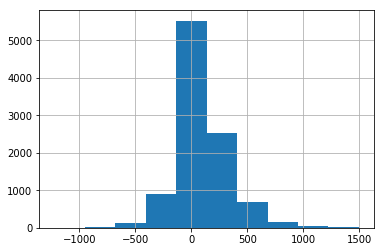

In [7]:
df.rating_difference[df.winner == 'white'].hist()

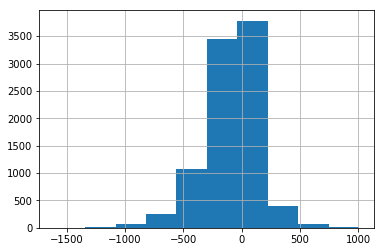

In [8]:
df.rating_difference[df.winner == 'black'].hist()

In [9]:
df.moves[0].split()

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [10]:
df.iloc[2]

id                                                            mIICvQHh
rated                                                             True
created_at                                                 1.50413e+12
last_move_at                                               1.50413e+12
turns                                                               61
victory_status                                                    mate
winner                                                           white
increment_code                                                    5+10
white_id                                                        ischia
white_rating                                                      1496
black_id                                                          a-00
black_rating                                                      1500
moves                e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
opening_eco                                                        C20
openin

In [11]:
df.moves.value_counts()

e4 e5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         27
e4 d5                                                                                                                                                                                                                                                                                                                                                                                  

In [12]:
def first_capture(moves):
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2==0:
                return 'white'
            else:
                return 'black'
    return None


def count_captures(moves):
    white_captures = 0
    black_captures = 0
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2 == 0:
                white_captures += 1
            else:
                black_captures += 1
    return [white_captures, black_captures]


def count_n_captures(moves, n=3):
    white_captures = 0
    black_captures = 0
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2 == 0:
                white_captures += 1
            else:
                black_captures += 1
        if white_captures == n or black_captures == n:
            return 'white' if white_captures == n else 'black'
        
def first_castle(moves):
    for index, move in enumerate(moves.split()):
        if move in ('O-O', 'O-O-O'):
            color = 'white' if index%2==0 else 'black'
            return '{}_{}'.format(color, move.replace("-", "_"))
    return None 


def make_features(df, n):
    df['count_captures'] = df['moves'].apply(count_captures)
    n_captures = [count_n_captures(move, n) for move in df['moves']]
    df[f'count_{n}_captures'] = n_captures
    df['first_castle'] = df['moves'].apply(first_castle)
    return df

In [13]:
raf_df = pd.read_csv("games.csv")
raf_df.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [14]:
raf_df = make_features(raf_df, n=5)
raf_df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,count_captures,count_5_captures,first_castle
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,"[2, 1]",None,None
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,"[2, 3]",None,None
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,"[14, 3]",white,None


In [15]:
raf_df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply',
       'count_captures', 'count_5_captures', 'first_castle'],
      dtype='object')

In [16]:
df = raf_df.copy()
print(df.columns)
df.head()

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply',
       'count_captures', 'count_5_captures', 'first_castle'],
      dtype='object')


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,count_captures,count_5_captures,first_castle
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,"[2, 1]",None,None
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,"[2, 3]",None,None
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,"[14, 3]",white,None
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,"[10, 4]",white,white_O_O
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,"[14, 10]",white,black_O_O


In [ ]:
#moves0 = raf_df.moves[0]
#first_capture(moves0), count_captures(moves0), count_n_captures(moves0, 2)

In [17]:
df.moves[6]

'd4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 Bd3 Bg4 O-O Nxd4 Be2 Nxe2+ Qxe2 Bxf3 Qxf3 Qd4+ Be3 Qg4 Qxb7 Rd8 Qc6+ Nd7 Nd5 e6 Nxc7+ Ke7 Bd2'

In [18]:
first_castle(df.moves[4])

'black_O_O'

In [19]:
# Splitting time into minutes and increment_seconds:
df['minutes'] = df['increment_code'].apply(lambda x: x.split('+')[0])

df['increment_secs'] = df['increment_code'].apply(lambda x: x.split('+')[1])
df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,count_captures,count_5_captures,first_castle,minutes,increment_secs
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,"[2, 1]",None,None,15,2
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,"[2, 3]",None,None,5,10
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,...,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,"[14, 3]",white,None,5,10


In [20]:
df.victory_status.value_counts()

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

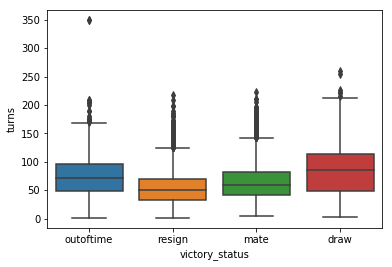

In [21]:
g = sns.boxplot(x = 'victory_status', y = 'turns', data = df)

In [22]:
#df.winner.replace({'black': 0, 'white': 1}, inplace=True)
df.rated.replace({False: 0, True: 1}, inplace=True)
print(df.winner.value_counts())
print('')
print(df.rated.value_counts())

white    10001
black     9107
draw       950
Name: winner, dtype: int64

1    16155
0     3903
Name: rated, dtype: int64


In [23]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,count_captures,count_5_captures,first_castle,minutes,increment_secs
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,"[2, 1]",None,None,15,2
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,"[2, 3]",None,None,5,10
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,...,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,"[14, 3]",white,None,5,10
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,...,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,"[10, 4]",white,white_O_O,20,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,...,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,"[14, 10]",white,black_O_O,30,3


In [24]:
# Drop unnecessary features from dataframe:
df.drop(['id', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
#df_target = df.winner
#df.drop(['winner'], axis=1, inplace=True)

In [25]:
df = df[df['winner'] != 'draw']
df.winner.unique()

array(['white', 'black'], dtype=object)

In [26]:
y.winner.unique()

NameError: name 'y' is not defined

In [27]:
# Winner vs. First move:

df[['first_move', 'winner', 'victory_status']].groupby(['first_move', 'winner']).count()#.plot(kind='barh')

#sns.barplot()

KeyError: "['first_move'] not in index"

In [ ]:
# Creating Dummies and Dropping Columns:
first_move_dummies = pd.get_dummies(df.first_move, prefix = 'first')
df.drop(['first_move'], axis=1, inplace=True)
df.drop(['moves'], axis=1, inplace=True)
df = pd.concat([df, first_move_dummies], axis=1)

# Removing games with no pieces captured and creating dummies
df = df[df.first_capture != 'no']
first_capture_dummies = pd.get_dummies(df.first_capture, prefix = 'first_cap')
df = pd.concat([df, first_capture_dummies], axis=1)

first_5_capture_dummies = pd.get_dummies(df.first_5_captures, prefix = 'first_5_cap')
df = pd.concat([df, first_5_capture_dummies], axis=1)

first_castle_dummies = pd.get_dummies(df.first_castle, prefix = 'first_castle')
df.drop(['first_castle'], axis=1, inplace=True)
df = pd.concat([df, first_castle_dummies], axis=1)

victory_status_dummies = pd.get_dummies(df.victory_status, prefix='victory')
df = pd.concat([df, victory_status_dummies], axis=1)
df.drop(['victory_status'], axis=1, inplace=True)

opening_eco_dummies = pd.get_dummies(df.opening_eco, prefix='opening_eco')
df.drop(['opening_eco'], axis=1, inplace=True)
df = pd.concat([df, opening_eco_dummies], axis=1)

df.drop(['opening_name', 'increment_code', ], axis=1, inplace=True)

df.head(10)

In [ ]:
#for col in df.columns:
#    print(df[col].value_counts())

In [ ]:
PCA_code = """
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
PCs = pca.fit_transform(first_move_dummies)

PCs_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
PCs_df = PCs_df.assign(winner = df['winner'])

sns.scatterplot(x = 'PC1', y = 'PC2',
                hue = 'winner',
                data = PCs_df,
                alpha = 0.5)

PCs_df.head()
"""

In [ ]:
# Selecting 8 most common first moves:
moves_to_use = first_move_dummies.sum().sort_values(ascending=False).head(8).index.tolist()
moves_to_use

In [ ]:
# Normalizing Rating Difference:
col = 'rating_difference'
df['rating_difference_norm'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

In [ ]:
# Reviewing Distribution:
df.rating_difference_norm.hist(density=True)

In [ ]:
df.describe()

In [ ]:
# Feature Engineering - How many of first 3 moves control/attack the center 'e4, e5, d4, d5'
# Possible moves:
#    - White: d3, d4, e3, e4, Nf3, Nc3, 
#    - Black:

In [ ]:
# Feature Engineering - Queen Side vs. King Side Castling:
# Implement this!!!

In [ ]:
# Choose X, y:
#X = df[['first_cap_black', 'first_5_cap_black', 'first_5_cap_white', 'rating_difference_norm', 'first_castle_white', 'first_castle_no', 'first_castle_black', '']]
#X = df.winner.drop(inplace=False)
#y = df['winner']

In [ ]:
#df.first_castle_black.unique()

In [ ]:
#df.first_5_cap_tie.unique()

In [ ]:
# This code would normalize columns: Should I run this before instead of just normalizing
# rating difference above?

#for col in df.columns:
#    df[col] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

In [ ]:
# INSTEAD: I would prefer to make target first column and just reference it by slicing
# instead of creating new dataframe. Is that better?

y = df[['winner']]
X = df.drop(['winner'], axis=1)

X.columns

In [ ]:
y.winner.value_counts()

In [ ]:
print(X.shape)
print(y.shape)
y.head( 3 )

In [ ]:
y.head()

In [ ]:
display(X.head())
display(y.head())

In [ ]:
#Normalize the Data
#for col in df.columns:
#    df[col] = (df[col]-min(df[col]))/ (max(df[col]) - min(df[col]))

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [ ]:
# Fit a model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, verbose=1) #Starter code
logreg.fit(X_train, y_train)
 #Preview model params
display(logreg)
# Predict
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [ ]:
logreg.score(X_test, y_test), logreg.score(X_train, y_train)

In [ ]:
train_residuals =  np.equal(y_train.values.reshape(1, -1), y_hat_train.reshape(1, -1))[0]
train_residuals

In [ ]:
X.shape

In [ ]:
for col in df.columns:
    print(col)

In [ ]:
for col1 in X.columns:
    for col2 in X.columns:
        if col2 == col1:
            pass
        else:
            corr = np.corrcoef(X[col1], X[col2])[0][1]
            if corr > 0.20:
                print(col1, col2, corr)

In [ ]:
'''
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    #Print the confusion matrix
    print(cm)
    
    #Create the basic matrix.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
'''

In [ ]:
# Creating function to plot confusion matrices:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Check if Normalization Option is Set to True. 
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
        
    # Print CNF Matrix
    print(cm)
    
    # Create the Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add Title, Axis Labels:
    # . classes = class_names
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add cell labels:
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

In [ ]:
# DF object has no att val_counts

#print(y_train.value_counts())
#print(y_test.value_counts())

In [ ]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [ ]:
# Train test split:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Fit a model:
#logreg = LogisticRegression(fit_intercept = False, C = 1e12) #Starter code
#model_log = logreg.fit(X_train, y_train)
#print(model_log) #Preview model params

# Predict:
#y_hat_test = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_hat_test, y_test)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
# Visualizing Normalized CNF Matrix:
class_names = set( y )
print( class_names )
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Normed CNF Matrix')
plt.show()

In [ ]:
# Initial Evaluation:
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

In [ ]:
# Fit a model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs') #Starter code

model_log = logreg.fit(X_train, y_train)
model_log #Preview model params

## ROC/AUC:

In [ ]:
#AUC/ROC Not yet working:

#Initial Model:
logreg = LogisticRegression(fit_intercept = False)

# Probability scores for test set:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False Positive Rate (fpr) and True Positive Rate (tpr):
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score, pos_label='white')

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Print AUC, Plot ROC Curve:
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="best")
plt.show()

In [ ]:
# Fit model:
#logreg = LogisticRegression(fit_intercept=False, C=1e12)
#model_log = logreg.fit(X_train, y_train)
#print(model_log) #preview params

# Predict:
#y_hat_test = logreg.predict(X_test)

Next we will employ various techniques in order to tune our initial model:

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    # Fit a model:
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    logreg = logreg.fit(X_train, y_train)
    print(logreg) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='white')
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='teal', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

Necessary?


### SMOTE:

Next, let's use the SMOTE class from imblearn to improve model performance on the minority class.

In [ ]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

In [ ]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y.winner.value_counts()

In [ ]:
y.head(10)

In [ ]:
# Calculate the probability scores of each of the datapoints:
#y_score = model_log.decision_function(X_test)

#fpr, tpr, thresholds = roc_curve(y_test, y_score)

#y_train_score = model_log.decision_function(X_train)
#train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [ ]:
# Create first model:
lr = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
rf = RandomForestClassifier(n_estimators = 100)
nb = MultinomialNB()

models = {
    'Logistic Regression' : lr,
    'Random Forest'       : rf,
    'Mult. Naive Bayes'   : nb
}

for name, model in models.items():
    model.fit(X, y)
    print(name, end = '')
    # Calculating Scores:
    scores = cross_val_score(model, X, y, cv=10)
    print(' - mean score: ', np.mean(scores))
    #print(scores)

## Pruning

In [ ]:
# Feature Importance
features = pd.DataFrame(columns = ['feature', 'importance'])
features['feature']    = X.columns
features['importance'] = rf.feature_importances_
features.sort_values('importance', ascending=False)

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
train_test_split(df)
X_train, X_test, y_train, y_test = train_test_split(df, df_features, test_size=.2)

In [ ]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')

model_log = logreg.fit(X_train, y_train)
model_log

## Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Train Decision Tree Classifier:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

In [ ]:
# Make Predictions for test data:
y_pred = classifier.predict(X_test)

In [ ]:
# Calculate Accuracy , AUC and Confusion matrix 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred, pos_label='white')
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
# Train a DT classifier using entropy:
classifier2 = DecisionTreeClassifier(random_state=10, criterion='entropy')  
classifier2.fit(X_train, y_train)  

# Make predictions for test data
y_pred = classifier2.predict(X_test) 

# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred, pos_label='white')
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Visualize the tree trained from complete dataset (optional)
dot_data = StringIO()
export_graphviz(classifier2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test, pos_label='white')

sns.set_style('whitegrid', {'axes.facecolor': '.9'})

print(f'AUC: {auc(fpr, tpr)}')
plt.figure(figsize=(8,6.5))
lw=2

plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC Curve')
plt.plot([0,1], [0,1], color='cyan', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(type(y_test))
print(type(y_pred))

In [ ]:
y_test.head()

In [ ]:
y_pred.head()

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(df_feature_dums, df_target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=42))])
        
pipe_dt = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])
'''

In [ ]:
'''
# Visualizing CNF Matrix:
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()
'''